<a href="https://colab.research.google.com/github/techwithanirudh/Shared/blob/master/FoodClasification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [2]:
# rmtree('/content/food-101')
# !tar xzvf /content/food-101.tar.gz

In [8]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.4.0
/device:GPU:0


In [9]:
# Helper function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [10]:
# Download data and extract it to folder
# Uncomment this below line if you are on Colab

get_data_extract()

Dataset already exists


In [11]:
!ls food-101/

images	license_agreement.txt  meta  README.txt


In [12]:
os.listdir('food-101/images')
os.listdir('food-101/meta')

['test.json',
 'classes.txt',
 'test.txt',
 'train.txt',
 'train.json',
 'labels.txt']

In [13]:
!head food-101/meta/train.txt
!head food-101/meta/classes.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856
apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


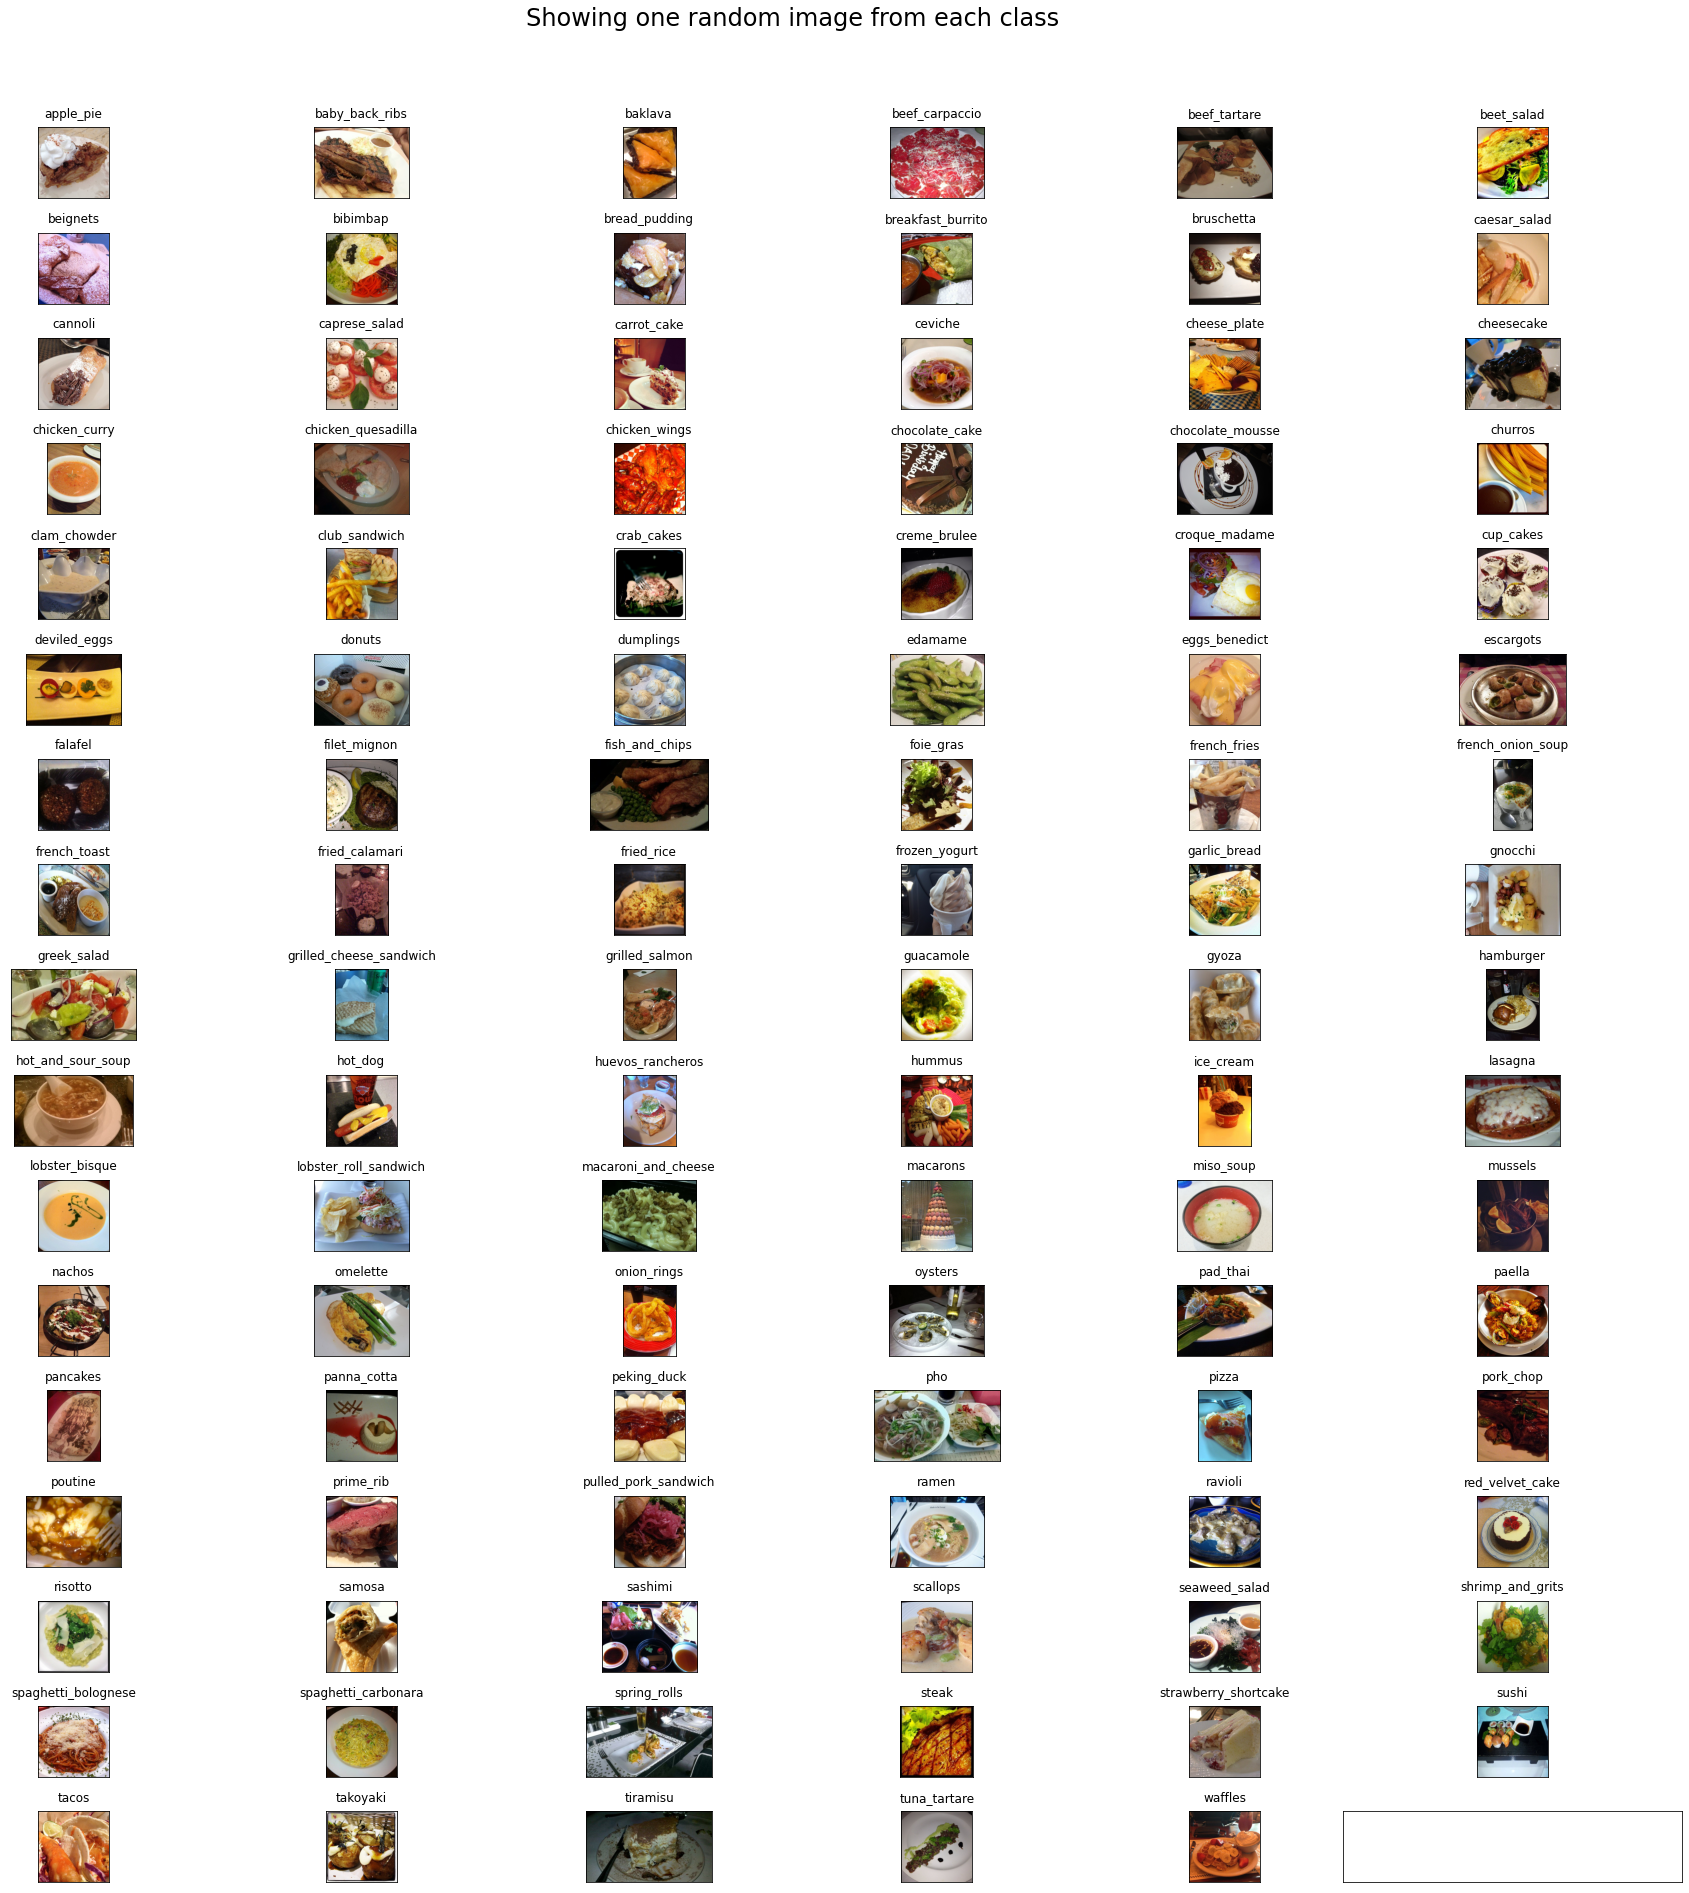

In [14]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html

In [15]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [18]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [21]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [33]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [23]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [24]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [25]:
foods_sorted

['baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich

In [34]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))
      

In [27]:
# picking 3 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [28]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [29]:
print("Total number of samples in train folder")

!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
2250


In [30]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [31]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
750


In [32]:
K.clear_session()
n_classes = 3
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
87916544/87910968 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
140/140 [==============================] - 81s 474ms/step - loss: 1.1375 - accuracy: 0.4039 - val_loss: 0.8746 - val_accuracy: 0.7106

Epoch 00001: val_loss improved from inf to 0.87455, saving model to best_model_3class.hdf5
Epoch 2/30
140/140 [==============================] - 64s 453ms/step - loss: 0.9059 - accuracy: 0.6289 - val_loss: 0.6885 - val_accuracy: 0.8098

Epoch 00002: val_loss improved from 0.87455 to 0.68845, saving model to best_model_3class.hdf5
Epoch 3/30
140/140 [==============================] - 64s 456ms/step - loss: 0.7268 - accuracy: 0.7618 - val_loss: 0.5394 - val_accuracy: 0.8546

Epoch 00003: val_loss improved from 0.68845 to 0.53941, saving model to best_model_3class.hdf5
Epoch 4/30
140/140 [==============================] - 64s 460ms/step - loss: 0.6099 - accuracy: 0.7890 - val_loss: 0.4443 - val_accuracy: 0.8804

Epoch 00004: val_loss improved from 0.53941 to 0.44435, saving model to best_model_3class.hdf5
Epoch 5/30
140/140 [====================

In [35]:
class_map_3 = train_generator.class_indices
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}

In [36]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()

def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

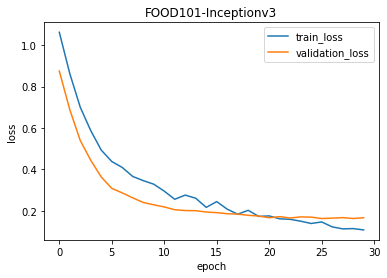

In [41]:
# plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

In [42]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_3class.hdf5',compile = False)

CPU times: user 1.73 s, sys: 89.4 ms, total: 1.82 s
Wall time: 1.81 s


In [43]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [45]:
# Downloading images from internet using the URLs
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O applepie.jpg https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
# !wget -O pizza.jpg http://104.130.3.186/assets/itemimages/400/400/3/default_9b4106b8f65359684b3836096b4524c8_pizza%20dreamstimesmall_94940296.jpg
!wget -O omelette.jpg https://www.incredibleegg.org/wp-content/uploads/basic-french-omelet-930x550.jpg

# If you have an image in your local computer and want to try it, uncomment the below code to upload the image files

# from google.colab import files
# image = files.upload()

--2021-01-06 09:31:08--  http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Resolving veggiefoodrecipes.com (veggiefoodrecipes.com)... 62.75.168.50
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|62.75.168.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75560 (74K) [image/jpeg]
Saving to: ‘samosa.jpg’

samosa.jpg          100%[===================>]  73.79K   183KB/s    in 0.4s    

2021-01-06 09:31:09 (183 KB/s) - ‘samosa.jpg’ saved [75560/75560]

--2021-01-06 09:31:09--  https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
Resolving acleanbake.com (acleanbake.com)... 138.197.203.41
Connecting to acleanbake.com (acleanbake.com)|138.197.203.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114276 (112K) [image/jpeg]
Saving to: ‘applepie.jpg’

applepie.jpg        100%[===================>] 111.60K  --.-KB/s    in 0.1s

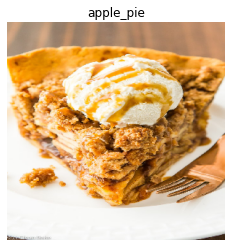

In [47]:
# Make a list of downloaded images and test the trained model
images = []
images.append('acb.jpg')
# images.append('pizza.jpg')
# images.append('abc.jpg')
predict_class(model_best, images, True)